In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
# -----------------------------------------------------------------------------
# Author: Zexiong Wu, Xueyou Li (wuzx58@mail2.sysu.edu.cn, lixueyou@mail.sysu.edu.cn)
# Date: 2024-06-09
# Description: Train PINN m-method for pile
# Article: https://link.cnki.net/urlid/32.1124.TU.20250926.1432.002
# -----------------------------------------------------------------------------

In [6]:
# Custom neural network
class CustomNetwork(nn.Module):
    def __init__(self, layers, activation=nn.Tanh(), is_TanhShrink=False):
        super().__init__()
        activation_list = [activation] * (len(layers) - 2)
        if is_TanhShrink:
            activation_list[0] = nn.Tanhshrink()
            activation_list[-1] = nn.Tanhshrink()
        self.networks = self.create_network(layers, activation_list)

    # Build the sequential network
    def create_network(self, layers, activation_list):
        network = nn.Sequential()
        for i in range(len(layers)-2):
            network.add_module('linear{}'.format(i+1), nn.Linear(layers[i], layers[i+1]))
            network.add_module('activation{}'.format(i+1), activation_list[i])
        network.add_module('output', nn.Linear(layers[-2], layers[-1]))
        return network
    
    # Forward pass with hard constraint
    def forward(self, inputs_list):
        xN, LpN, MtN, VtN = inputs_list
        inputs_tensor = torch.cat(inputs_list, dim=1)
        outputs_tensor = self.networks(inputs_tensor)
        # Apply hard constraint
        y = outputs_tensor[:, 0].unsqueeze(1) * MtN + outputs_tensor[:, 1].unsqueeze(1) * VtN
        return y
    
    # Output all required physical quantities
    def outputs(self, input_list):
        '''input_list: [x, Mt, Vt, EI, Lp, m, b0]'''
        x, Mt, Vt, EI, Lp, m, b0 = input_list
        alpha = (m * b0 / EI)**(1 / 5)
        xN = x * alpha
        LpN = Lp * alpha
        VtN = Vt / (EI * alpha**3)
        MtN = Mt / (EI * alpha**2)
        y = self.forward([xN, LpN, MtN, VtN])
        dy = gradients(y, x, 1)
        d2y = gradients(dy, x, 1)
        d3y = gradients(d2y, x, 1)
        d4y = gradients(d3y, x, 1)
        return [y, dy, d2y*EI, d3y*EI, d4y*EI]

# Compute gradients of u with respect to x
def gradients(u, x, order=1):
    if order == 1:
        return torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u),
                                   create_graph=True,
                                   retain_graph=True,
                                   only_inputs=True,)[0]
    else:
        return gradients(gradients(u, x), x, order=order - 1)

# Mean squared error
def MS(equ):
    return torch.mean(equ**2)

In [7]:
# Define the ranges for the parameters
LpN_range = [1.5, 5]
VtN_range = [0, 0.01]
MtN_range = [0, 0.01]

layers = [4] + [50] * 4 + [2]
model = CustomNetwork(layers, is_TanhShrink=True)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

losses_list = []
epoch_sum = 0
t_sum = 0

In [23]:
epochs = 500000
Nr = 500
MSE = torch.nn.MSELoss()
device = 'cuda'
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

for epoch in range(epochs):
    optimizer.zero_grad()
    
    # Input sampling
    if epoch_sum % 100 == 0 or epoch == 0:
        LpN = torch.rand(Nr, 1, device=device) * (LpN_range[1] - LpN_range[0]) + LpN_range[0]
        VtN = torch.rand(Nr, 1, device=device) * (VtN_range[1] - VtN_range[0]) + VtN_range[0]
        MtN = torch.rand(Nr, 1, device=device) * (MtN_range[1] - MtN_range[0]) + MtN_range[0]
        xN = (torch.rand(Nr, 1, device=device) * LpN).requires_grad_(True)
        xN0 = torch.zeros(Nr, 1, device=device, requires_grad=True)
        xN1 = (torch.ones(Nr, 1, device=device) * LpN).requires_grad_(True)
    
    y = model([xN, LpN, MtN, VtN])
    y0 = model([xN0, LpN, MtN, VtN])
    y1 = model([xN1, LpN, MtN, VtN])
    
    d4y = gradients(y, xN, 4)
    d2y0 = gradients(y0, xN0, 2)
    d3y0 = gradients(d2y0, xN0, 1)
    d2y1 = gradients(y1, xN1, 2)
    d3y1 = gradients(d2y1, xN1, 1)
    
    # Loss functions
    loss_gov = MS(d4y + xN * y)
    loss_Mt = MS(d2y0 - MtN)
    loss_Vt = MS(d3y0 - VtN)
    loss_Mb = MS(d2y1)
    loss_Vb = MS(d3y1)

    loss_list = [loss_gov, loss_Mt, loss_Vt, loss_Mb, loss_Vb]
    loss_legend = ['gov', 'Mt', 'Vt', 'Mb', 'Vb']
    loss_sum = torch.sum(torch.stack(loss_list))
    loss_sum.backward()
    optimizer.step()

    losses_list.append([loss.item() for loss in loss_list])
    epoch_sum += 1
    loss_n = loss_sum / torch.sum(torch.tensor(losses_list[0]))

    if epoch_sum % 500 == 0:
        print('Epoch: {}'.format(epoch_sum))
        print(loss_legend)
        print('loss: ', [loss.item() for loss in loss_list])
        print('loss_n :', loss_n.item())
    

Epoch: 18000
['gov', 'Mt', 'Vt', 'Mb', 'Vb']
loss:  [3.565642714420392e-08, 2.426708256564325e-08, 2.5016944960043475e-08, 2.80490102255726e-08, 9.529250277751089e-09]
loss_n : 0.0018061769660562277
Epoch: 18500
['gov', 'Mt', 'Vt', 'Mb', 'Vb']
loss:  [4.045464407909094e-08, 3.048079477707688e-08, 3.162363881870078e-08, 3.8003062030611545e-08, 1.4204334597422985e-08]
loss_n : 0.002281574998050928
Epoch: 19000
['gov', 'Mt', 'Vt', 'Mb', 'Vb']
loss:  [3.732262854327928e-08, 2.0366186959108745e-08, 2.020883549391783e-08, 3.0701915676445424e-08, 1.0884111389941609e-08]
loss_n : 0.001761434250511229
Epoch: 19500
['gov', 'Mt', 'Vt', 'Mb', 'Vb']
loss:  [3.055264130580326e-08, 1.69214722234301e-08, 1.876257904598333e-08, 2.1577868380973086e-08, 8.135681461851618e-09]
loss_n : 0.0014145032037049532
Epoch: 20000
['gov', 'Mt', 'Vt', 'Mb', 'Vb']
loss:  [2.9613323349053644e-08, 1.816295558398906e-08, 1.9416232177604797e-08, 2.0850544402151172e-08, 7.751449260240406e-09]
loss_n : 0.0014122073771432042

KeyboardInterrupt: 

In [24]:
# save model
def save_model(filename, model):
    torch.save(model.state_dict(), filename + '.pth')
save_model('PINN_m_method_pile', model)

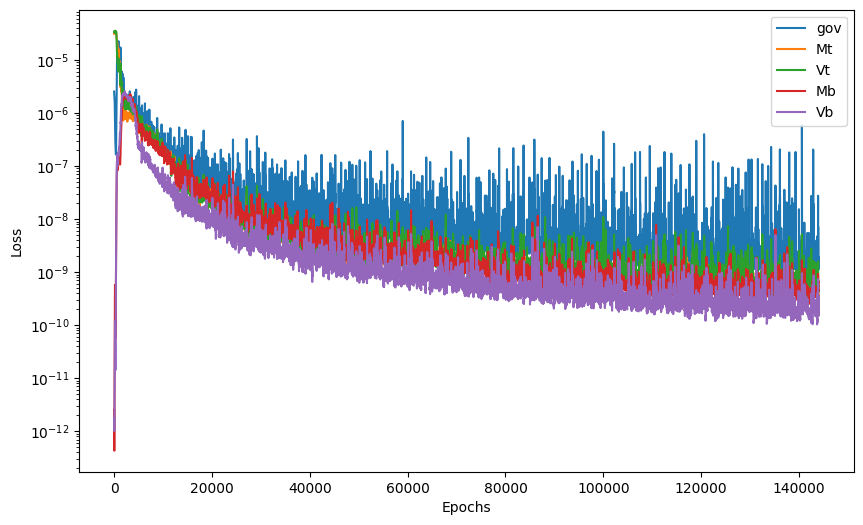

In [25]:
# Plt the losses
losses_array = np.array(losses_list)
plt.figure(figsize=(10, 6))
for i in range(losses_array.shape[1]):
    plt.semilogy(losses_array[:, i], label=loss_legend[i])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

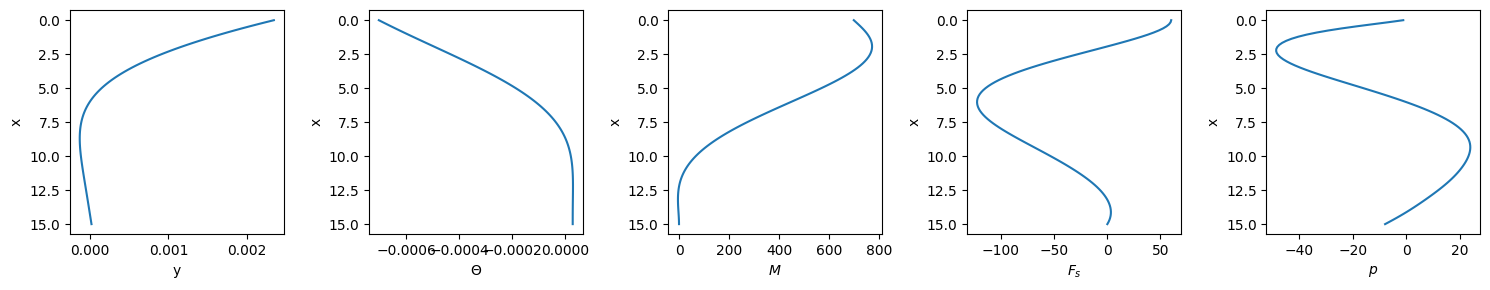

In [26]:
# Predict
Lp = 15
E = 2.8e7
Vt = 60
Mt = 700
D = 1.5
b0 = 2.25
m = 9400

EI = E * (np.pi * D**4) / 64
model.to('cpu')
x = torch.linspace(0, Lp, 100).view(-1, 1).requires_grad_(True)
input_list = [x, Mt*torch.ones_like(x), Vt*torch.ones_like(x), EI*torch.ones_like(x),
              Lp*torch.ones_like(x), m*torch.ones_like(x), b0*torch.ones_like(x)]
output_list = model.outputs(input_list)

plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.plot(output_list[i].detach().numpy(), x.detach().numpy())
    plt.gca().invert_yaxis()
    plt.ylabel('x')
    plt.xlabel(['y', '$\Theta$', '$M$', '$F_s$', '$p$'][i])
    plt.tight_layout()
